In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from data import DataLoader
from db import make_session, d_models
import lin_fit
from plot import set_font_size, unity_line

import CONFIG as C
import LOCAL_SETTINGS as L

In [2]:
FILT = [d_models.Trial.expt == 'driven_random']

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx='0', vel_filt=None)

Loading data for trial 1/5 (20170428.Fly1.5)
Loading clean data from file "clean_0.csv"...
Loading data for trial 2/5 (20170428.Fly2.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 3/5 (20170428.Fly5.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 4/5 (20170428.Fly5.5)
Loading clean data from file "clean_0.csv"...
Loading data for trial 5/5 (20170428.Fly1.4)
Loading clean data from file "clean_0.csv"...


In [3]:
ts = {e_ctr: [] for e_ctr in range(len(C.DRIVEN_RANDOM_EPOCHS))}
g4ds = {e_ctr: [] for e_ctr in range(len(C.DRIVEN_RANDOM_EPOCHS))}
ddt_g4ds = {e_ctr: [] for e_ctr in range(len(C.DRIVEN_RANDOM_EPOCHS))}
speeds = {e_ctr: [] for e_ctr in range(len(C.DRIVEN_RANDOM_EPOCHS))}
v_angs = {e_ctr: [] for e_ctr in range(len(C.DRIVEN_RANDOM_EPOCHS))}
v_airs = {e_ctr: [] for e_ctr in range(len(C.DRIVEN_RANDOM_EPOCHS))}

for trial in trials:
    for e_ctr, (t_start, t_end) in enumerate(C.DRIVEN_RANDOM_EPOCHS):
        
        t = trial.dl.t
        mask = (t_start <= t) & (t < t_end)
        
        ts[e_ctr].append(trial.dl.t[mask])
        g4ds[e_ctr].append(trial.dl.g4d[mask])
        ddt_g4ds[e_ctr].append(trial.dl.ddt_g4d[mask])
        speeds[e_ctr].append(trial.dl.speed[mask])
        v_angs[e_ctr].append(trial.dl.v_ang[mask])
        v_airs[e_ctr].append(trial.dl.v_air[mask])

Driven epoch 1:
v_air (mean of variance)/(variance of mean) = 0.0074
g4d (mean of variance)/(variance of mean) = 0.9441
ddt_g4d (mean of variance)/(variance of mean) = 1.3512
v_ang (mean of variance)/(variance of mean) = 2.8084
speed (mean of variance)/(variance of mean) = 4.8721

Driven epoch 2:
v_air (mean of variance)/(variance of mean) = 0.0141
g4d (mean of variance)/(variance of mean) = 0.8224
ddt_g4d (mean of variance)/(variance of mean) = 1.0084
v_ang (mean of variance)/(variance of mean) = 2.3031
speed (mean of variance)/(variance of mean) = 4.8275



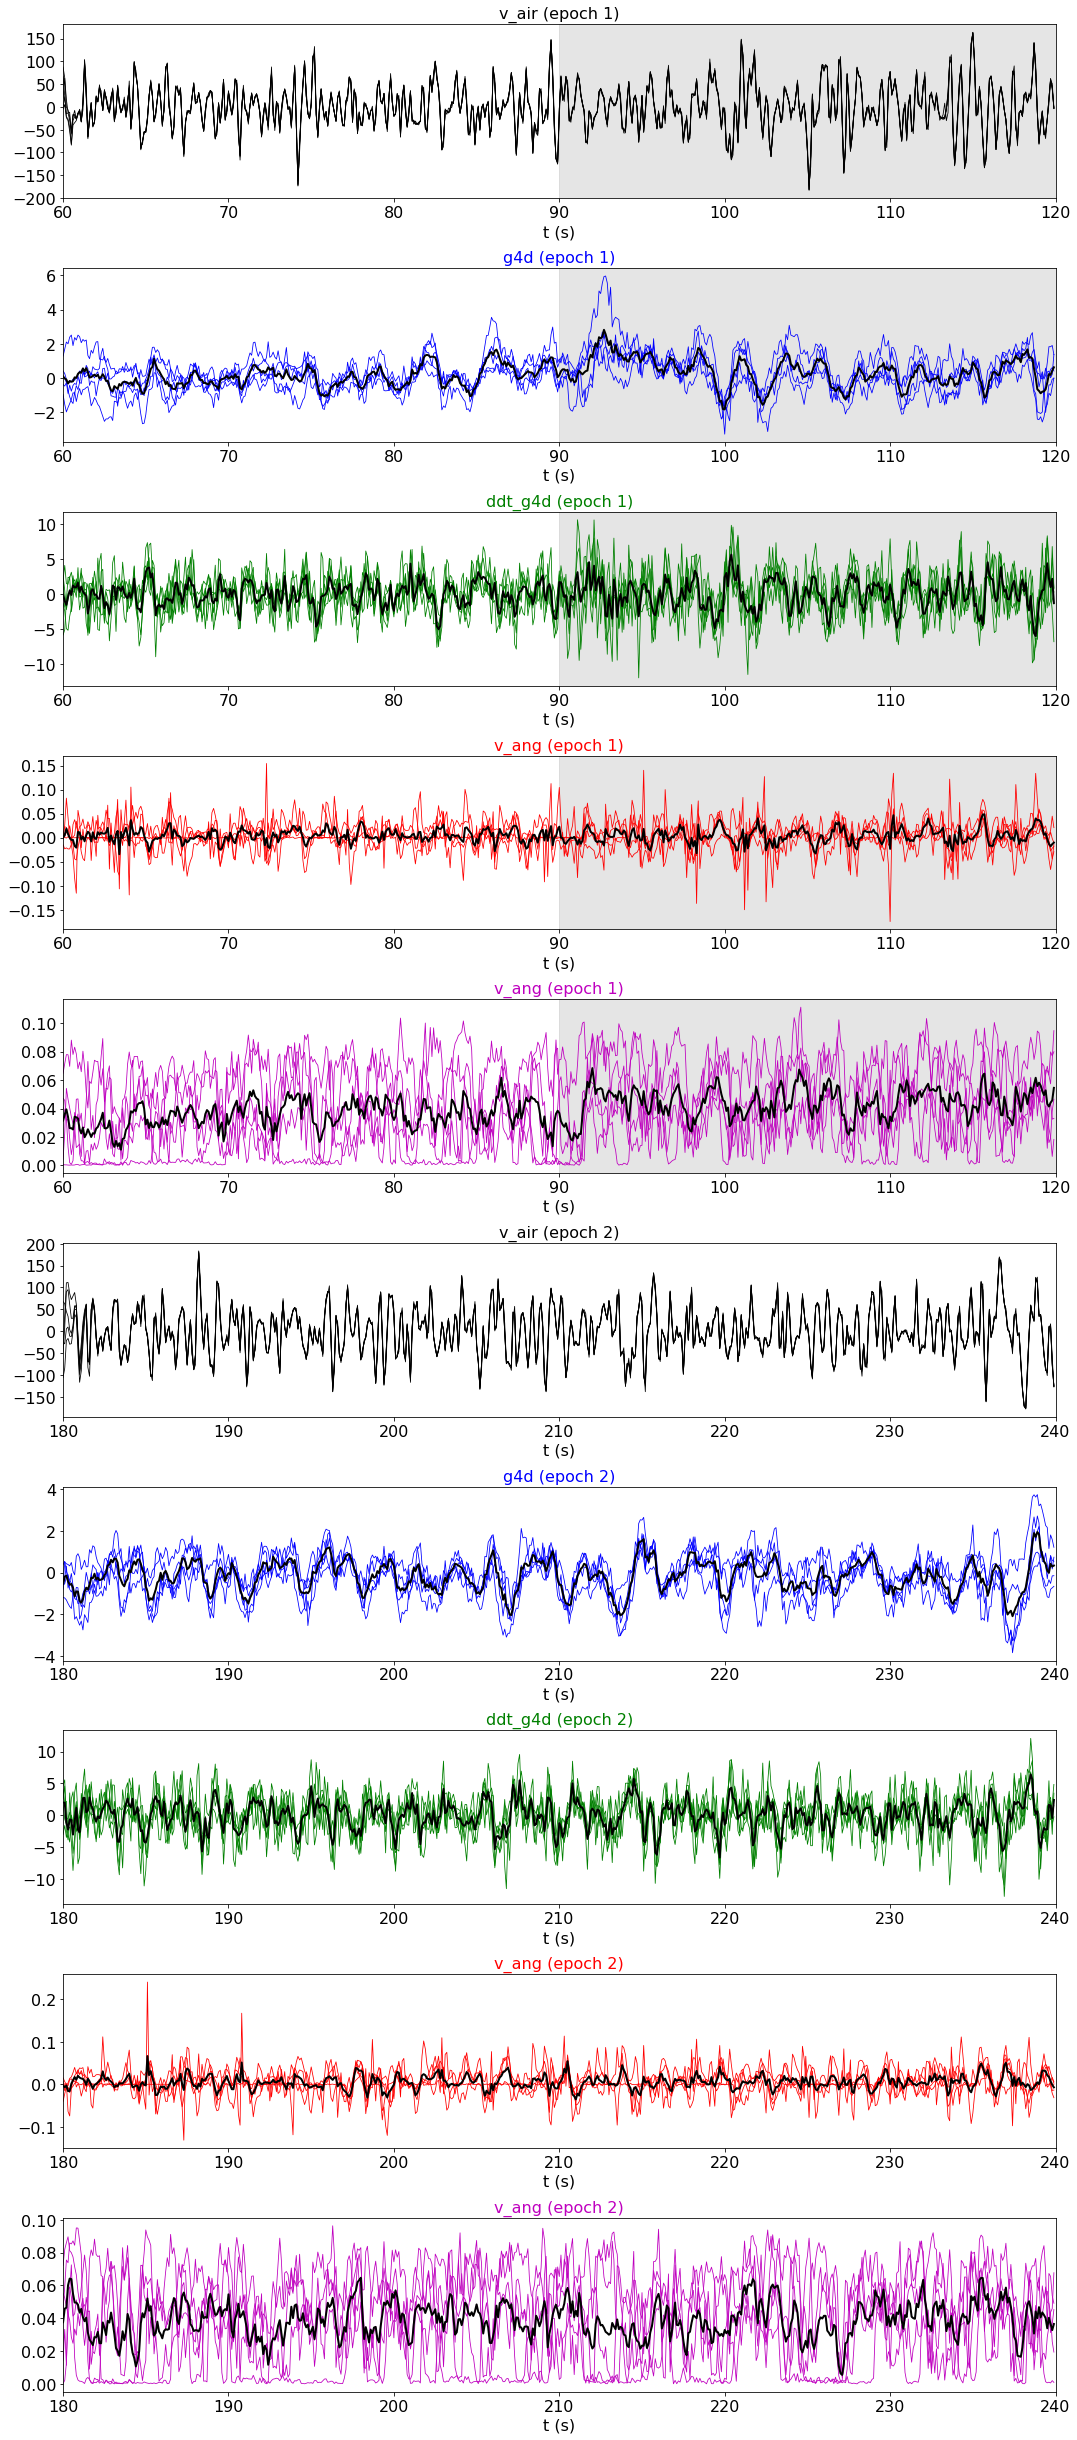

In [4]:
fig, axs = plt.subplots(10, 1, figsize=(15, 34), tight_layout=True, squeeze=False)
axs = axs[:, 0]

for e_ctr, (t_start, t_end) in enumerate(C.DRIVEN_RANDOM_EPOCHS):
    offset = e_ctr * 5
    
    # plot individual trials
    for ctr in range(len(trials)):
        axs[offset].plot(ts[e_ctr][ctr], v_airs[e_ctr][ctr], color='k', lw=.8)
        axs[offset+1].plot(ts[e_ctr][ctr], g4ds[e_ctr][ctr], color='b', lw=.8)
        axs[offset+2].plot(ts[e_ctr][ctr], ddt_g4ds[e_ctr][ctr], color='g', lw=.8)
        axs[offset+3].plot(ts[e_ctr][ctr], v_angs[e_ctr][ctr], color='r', lw=.8)
        axs[offset+4].plot(ts[e_ctr][ctr], speeds[e_ctr][ctr], color='m', lw=.8)

    # plot averages
    axs[offset+1].plot(ts[e_ctr][ctr], np.mean(g4ds[e_ctr], axis=0), color='k', lw=2)
    axs[offset+2].plot(ts[e_ctr][ctr], np.mean(ddt_g4ds[e_ctr], axis=0), color='k', lw=2)
    axs[offset+3].plot(ts[e_ctr][ctr], np.mean(v_angs[e_ctr], axis=0), color='k', lw=2)
    axs[offset+4].plot(ts[e_ctr][ctr], np.mean(speeds[e_ctr], axis=0), color='k', lw=2)
    
    # shade odor time
    for ax in axs[offset:offset+5]:
        ax.axvspan(C.ODOR_START, C.ODOR_END, color='gray', alpha=0.2)
        
    axs[offset].set_xlim(t_start, t_end)
    axs[offset].set_xlabel('t (s)')
    axs[offset].set_title('v_air (epoch {})'.format(e_ctr+1))
    axs[offset+1].set_xlim(t_start, t_end)
    axs[offset+1].set_xlabel('t (s)')
    axs[offset+1].set_title('g4d (epoch {})'.format(e_ctr+1), color='b')
    axs[offset+2].set_xlim(t_start, t_end)
    axs[offset+2].set_xlabel('t (s)')
    axs[offset+2].set_title('ddt_g4d (epoch {})'.format(e_ctr+1), color='g')
    axs[offset+3].set_xlim(t_start, t_end)
    axs[offset+3].set_xlabel('t (s)')
    axs[offset+3].set_title('v_ang (epoch {})'.format(e_ctr+1), color='r')
    axs[offset+4].set_xlim(t_start, t_end)
    axs[offset+4].set_xlabel('t (s)')
    axs[offset+4].set_title('v_ang (epoch {})'.format(e_ctr+1), color='m')
    
    print('Driven epoch {}:'.format(e_ctr+1))
    
    print('v_air (mean of variance)/(variance of mean) = {0:.4f}'.format(
        np.mean(np.var(v_airs[e_ctr], axis=0)) / np.var(np.mean(v_airs[e_ctr], axis=0))))
    
    print('g4d (mean of variance)/(variance of mean) = {0:.4f}'.format(
        np.mean(np.var(g4ds[e_ctr], axis=0)) / np.var(np.mean(g4ds[e_ctr], axis=0))))
    
    print('ddt_g4d (mean of variance)/(variance of mean) = {0:.4f}'.format(
        np.mean(np.var(ddt_g4ds[e_ctr], axis=0)) / np.var(np.mean(ddt_g4ds[e_ctr], axis=0))))
    
    print('v_ang (mean of variance)/(variance of mean) = {0:.4f}'.format(
        np.mean(np.var(v_angs[e_ctr], axis=0)) / np.var(np.mean(v_angs[e_ctr], axis=0))))
    
    print('speed (mean of variance)/(variance of mean) = {0:.4f}'.format(
        np.mean(np.var(speeds[e_ctr], axis=0)) / np.var(np.mean(speeds[e_ctr], axis=0))))
    
    print('')

for ax in axs:
    ax.axvline(0, color='gray', ls='--')
    set_font_size(ax, 16)

Now plot the DAN responses colored by when the fly is and isn't walking.

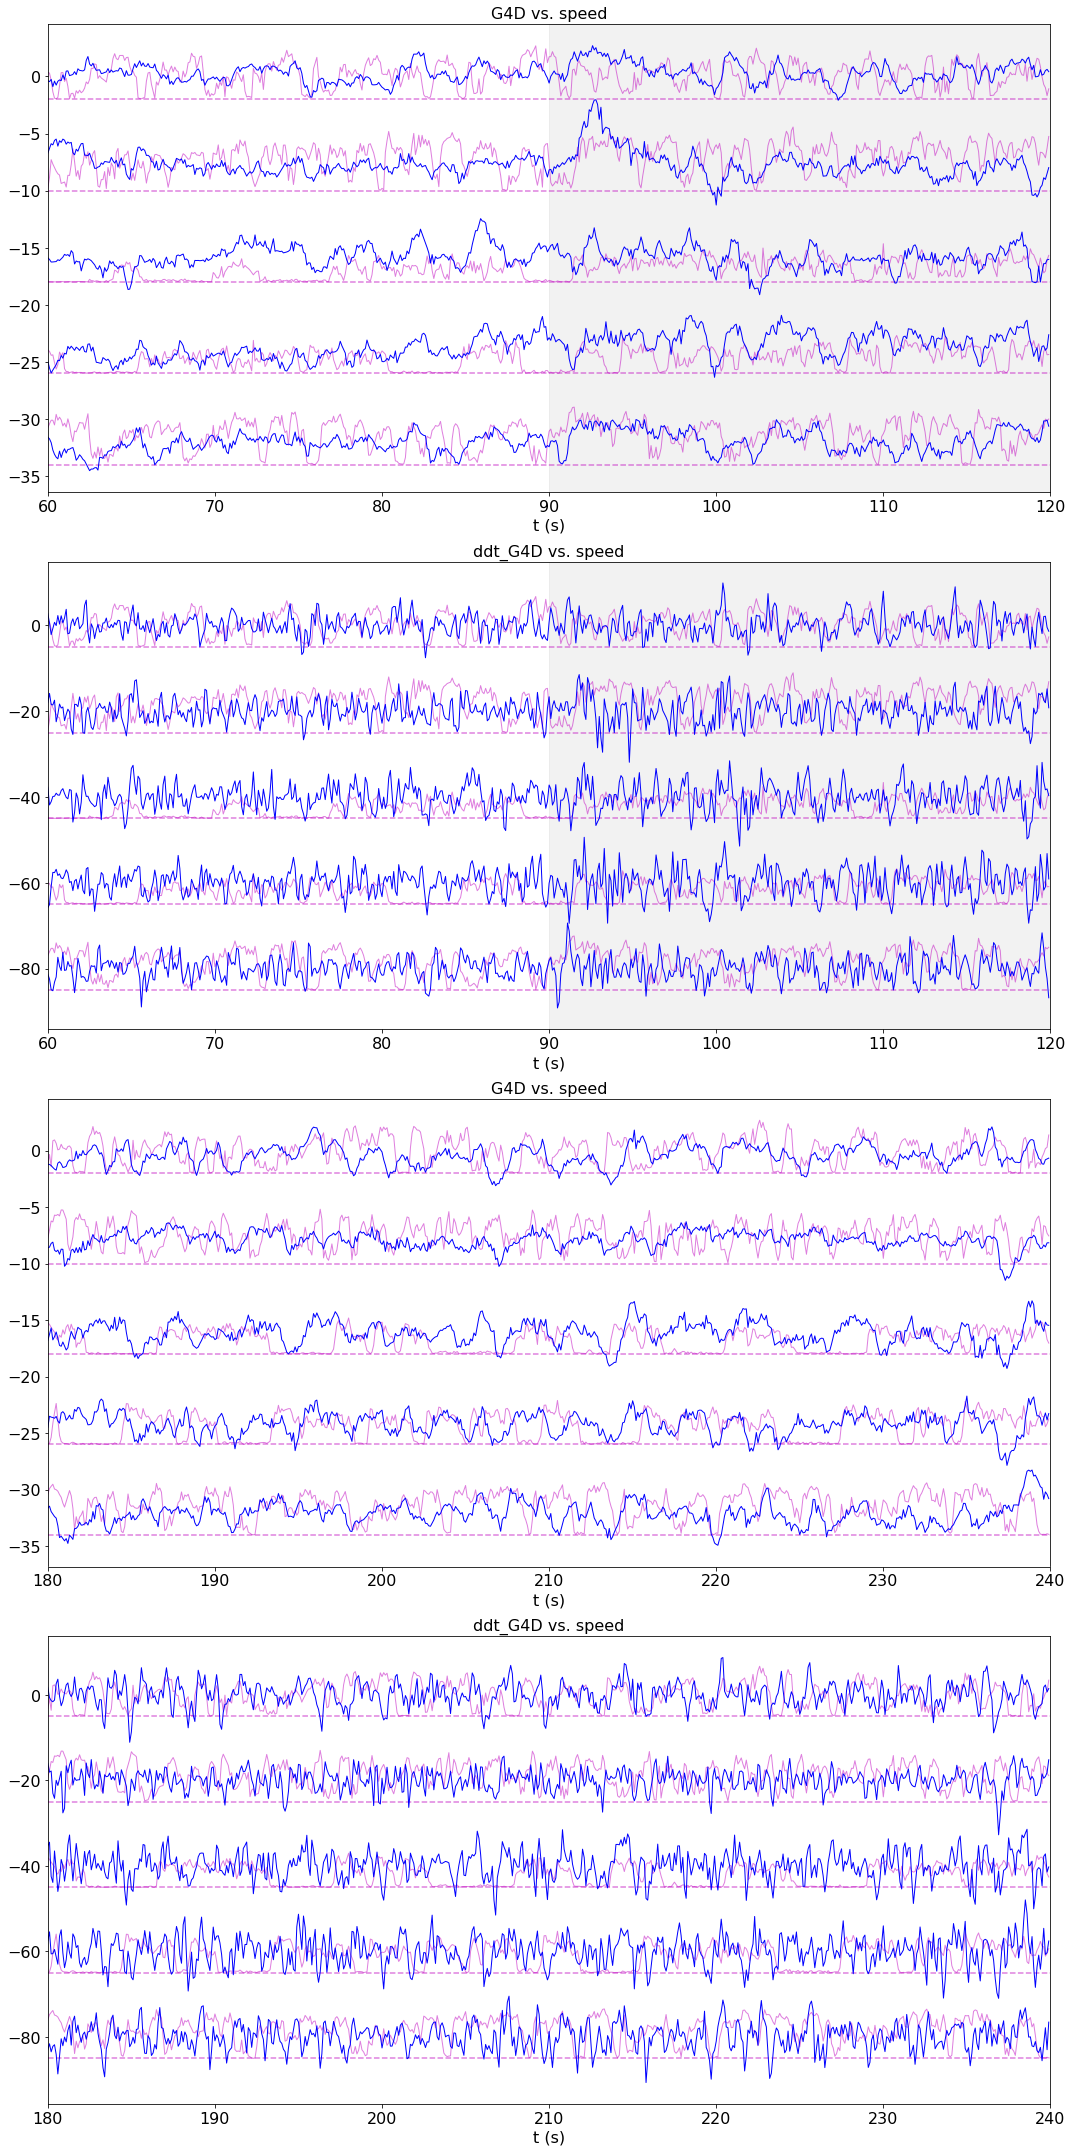

In [5]:
OFFSET_G4D = 8
OFFSET_DDT_G4D = 20

SPEED_G4D_SCALE = 4/0.08
SPEED_DDT_G4D_SCALE = 10/0.08
SPEED_MIDDLE = 0.04

fig, axs = plt.subplots(4, 1, figsize=(15, 30), tight_layout=True, squeeze=False)
axs = axs[:, 0]

for e_ctr, (t_start, t_end) in enumerate(C.DRIVEN_RANDOM_EPOCHS):
    ax_offset = e_ctr * 2
    
    # plot individual trials
    for ctr in range(len(trials)):
        t = ts[e_ctr][ctr]
        speed = speeds[e_ctr][ctr].copy()
        g4d = g4ds[e_ctr][ctr].copy()
        ddt_g4d = ddt_g4ds[e_ctr][ctr].copy()
        
        # plot speed
        y_offset_g4d = -OFFSET_G4D*ctr
        speed_g4d = (speed - SPEED_MIDDLE)*SPEED_G4D_SCALE + y_offset_g4d
        zero_line_g4d = -SPEED_MIDDLE*SPEED_G4D_SCALE + y_offset_g4d
        axs[ax_offset].plot(t, speed_g4d, color='m', alpha=0.5, lw=1)
        axs[ax_offset].axhline(zero_line_g4d, color='m', ls='--', alpha=0.5)
        # plot g4d
        axs[ax_offset].plot(t, g4d+y_offset_g4d, color='b', lw=1)
        
        # plot speed
        y_offset_ddt_g4d = -OFFSET_DDT_G4D*ctr
        speed_ddt_g4d = (speed - SPEED_MIDDLE)*SPEED_DDT_G4D_SCALE + y_offset_ddt_g4d
        zero_line_ddt_g4d = -SPEED_MIDDLE*SPEED_DDT_G4D_SCALE + y_offset_ddt_g4d
        axs[ax_offset+1].plot(t, speed_ddt_g4d, color='m', alpha=0.5, lw=1)
        axs[ax_offset+1].axhline(zero_line_ddt_g4d, color='m', ls='--', alpha=0.5)
        # plot g4d
        axs[ax_offset+1].plot(t, ddt_g4d+y_offset_ddt_g4d, color='b', lw=1)

    
    # shade odor time
    for ax in axs[ax_offset:ax_offset+2]:
        ax.axvspan(C.ODOR_START, C.ODOR_END, color='gray', alpha=0.1)
        
    axs[ax_offset].set_xlim(t_start, t_end)
    axs[ax_offset].set_xlabel('t (s)')
    axs[ax_offset].set_title('G4D vs. speed')
    axs[ax_offset+1].set_xlim(t_start, t_end)
    axs[ax_offset+1].set_xlabel('t (s)')
    axs[ax_offset+1].set_title('ddt_G4D vs. speed')
    
for ax in axs.flat:
    ax.yaxis.label.set_visible(False)
    set_font_size(ax, 16)

# Fit linear filters predicting G4D from v_air

To do this we will create a single predictor matrix and single target vector, aggregating across both epochs in all trials, since the responses appear to be so consistent. We will ignore only the first 10s of the odor onset (90-100s), since that seems to introduce some temporary variance unlikely due to the air tube velocity.

In [62]:
%reset -f
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from aux import make_extended_predictor_matrix
from data import DataLoader
from db import make_session, d_models
import lin_fit
from plot import set_font_size, unity_line

import CONFIG as C
import LOCAL_SETTINGS as L

cc = np.concatenate

In [63]:
FILT = [d_models.Trial.expt == 'driven_random']

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx='0', vel_filt=None)

Loading data for trial 1/5 (20170428.Fly1.5)
Loading clean data from file "clean_0.csv"...
Loading data for trial 2/5 (20170428.Fly2.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 3/5 (20170428.Fly5.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 4/5 (20170428.Fly5.5)
Loading clean data from file "clean_0.csv"...
Loading data for trial 5/5 (20170428.Fly1.4)
Loading clean data from file "clean_0.csv"...


First build predictor matrices for each epoch in each trial.

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal


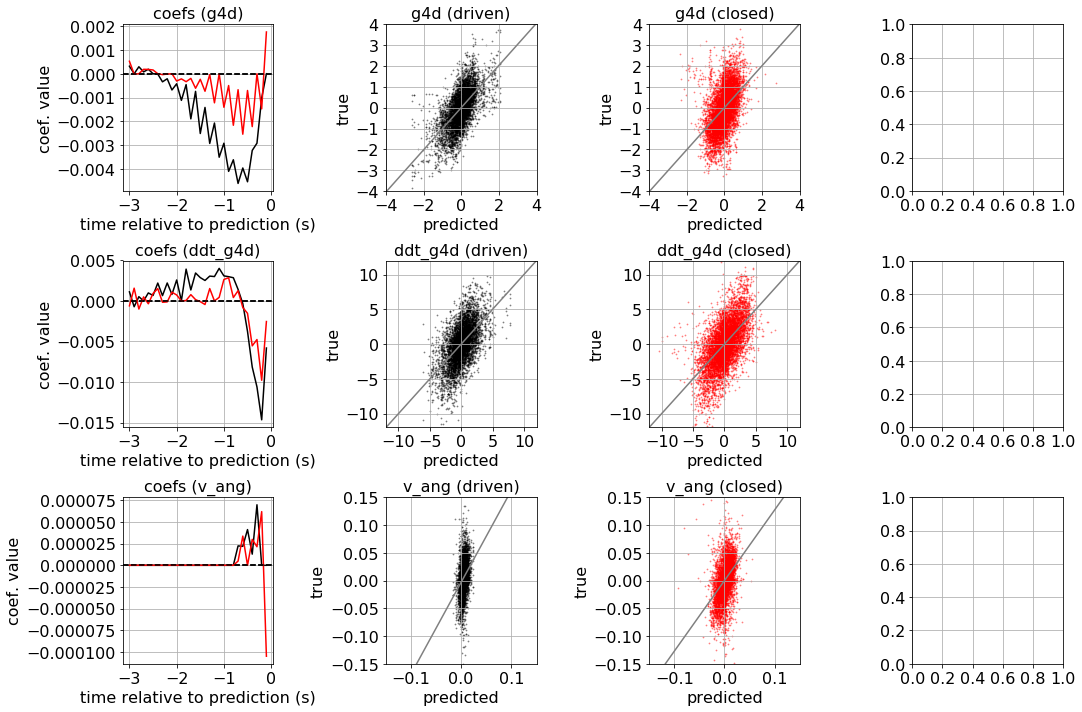

In [64]:
FILT_LEN = 30  # timesteps
CLOSED_LOOP_EPOCHS = [(0, 60), (120, 180), (240, 300)]
MODEL = Lasso(alpha=0.1)

v_airs = {'driven': [], 'closed': []}
g4ds = {'driven': [], 'closed': []}
ddt_g4ds = {'driven': [], 'closed': []}
v_angs = {'driven': [], 'closed': []}

valid = {'driven': None, 'closed': None}
targs = {'driven': None, 'closed': None}
rgrs = {'driven': None, 'closed': None}
errs = {'driven': None, 'closed': None}

for trial in trials:
    
    t = trial.dl.t
    
    # prepare driven predictors and targets
    for ctr, (t_start, t_end) in enumerate(C.DRIVEN_RANDOM_EPOCHS):
        mask = (t_start <= t) & (t < t_end)
    
        # get epoch
        t_ = t[mask]
        v_air_ = trial.dl.v_air[mask]
        g4d = trial.dl.g4d[mask]
        ddt_g4d = trial.dl.ddt_g4d[mask]
        v_ang = trial.dl.v_ang[mask]
    
        # remove 10s following odor onset (only applicable in first epoch)
        odor_onset_mask = (C.ODOR_START <= t_) & (t_ < C.ODOR_START+10)
        g4d[odor_onset_mask] = np.nan
        ddt_g4d[odor_onset_mask] = np.nan
        v_ang[odor_onset_mask] = np.nan
    
        # get full v_air predictor matrix
        v_air = make_extended_predictor_matrix(
            vs={'v_air': v_air_}, windows={'v_air': (-FILT_LEN, 0)}, order=['v_air'])
    
        # store results
        v_airs['driven'].append(v_air.copy())
        g4ds['driven'].append(g4d.copy())
        ddt_g4ds['driven'].append(ddt_g4d.copy())
        v_angs['driven'].append(v_ang.copy())
    
    # prepare closed loop predictors and targets
    for ctr, (t_start, t_end) in enumerate(CLOSED_LOOP_EPOCHS):
        mask = (t_start <= t) & (t < t_end)
    
        # get epoch
        t_ = t[mask]
        air = trial.dl.air[mask]
        v_air_ = trial.dl.v_air[mask]
        g4d = trial.dl.g4d[mask]
        ddt_g4d = trial.dl.ddt_g4d[mask]
        v_ang = trial.dl.v_ang[mask]
    
        # remove 10s following odor offset (only applicable in second epoch)
        odor_onset_mask = (C.ODOR_END <= t_) & (t_ < C.ODOR_END+10)
        g4d[odor_onset_mask] = np.nan
        ddt_g4d[odor_onset_mask] = np.nan
        v_ang[odor_onset_mask] = np.nan
        
        # remove all points where the air tube is greater than 90 deg from uw
        air_invalid_mask = np.abs(air) >= 90
        v_air_[air_invalid_mask] = np.nan
    
        # get full v_air predictor matrix
        v_air = make_extended_predictor_matrix(
            vs={'v_air': v_air_}, windows={'v_air': (-FILT_LEN, 0)}, order=['v_air'])
    
        # store results
        v_airs['closed'].append(v_air.copy())
        g4ds['closed'].append(g4d.copy())
        ddt_g4ds['closed'].append(ddt_g4d.copy())
        v_angs['closed'].append(v_ang.copy())
    
# fit models
for cdtn in ['driven', 'closed', 'control']:
    
    if cdtn != 'control':
        # concatenate data into full predictor matrix and targ vectors
        v_airs[cdtn] = cc(v_airs[cdtn], axis=0)
        g4ds[cdtn] = cc(g4ds[cdtn], axis=0)[:, None]
        ddt_g4ds[cdtn] = cc(ddt_g4ds[cdtn], axis=0)[:, None]
        v_angs[cdtn] = cc(v_angs[cdtn], axis=0)[:, None]

        # remove nans
        valid[cdtn] = np.all(
            ~np.isnan(cc([v_airs[cdtn], g4ds[cdtn], ddt_g4ds[cdtn], v_angs[cdtn]], axis=1)), axis=1)

        targs[cdtn] = cc([g4ds[cdtn], ddt_g4ds[cdtn], v_angs[cdtn]], axis=1)

    else:
        # build positive control dataset using closed loop v_air inputs passed through
        # best-fit open loop filters
        v_airs[cdtn] = v_airs['closed'].copy()
        valid[cdtn] = valid['closed'].copy()
        targs[cdtn] = np.nan * np.zeros((len(v_airs['closed']), 3))
        targs[cdtn][valid['closed'], :] = rgrs['driven'].predict(v_airs['closed'][valid['closed']])
        # add noise
        targs[cdtn] += errs['closed']
        
    # fit linear regression
    rgrs[cdtn] = deepcopy(MODEL)
    rgrs[cdtn].fit(v_airs[cdtn][valid[cdtn]], targs[cdtn][valid[cdtn]])
    
    errs[cdtn] = np.nan * np.zeros(targs[cdtn].shape)
    errs[cdtn][valid[cdtn]] = targs[cdtn][valid[cdtn]] - rgrs[cdtn].predict(v_airs[cdtn][valid[cdtn]])
    
# plot found filters
LIMS = {'g4d': (-4, 4), 'ddt_g4d': (-12, 12), 'v_ang': (-.15, .15)}

fig, axs = plt.subplots(3, 4, figsize=(15, 10), tight_layout=True)

for t_ctr, label in enumerate(['g4d', 'ddt_g4d', 'v_ang']):
    for cdtn, color, scatter_ax in zip(['driven', 'closed'], ['k', 'r', 'b'], [1, 2, 3]):
        
        # filters
        axs[t_ctr, 0].plot(C.DT * np.arange(-FILT_LEN, 0), rgrs[cdtn].coef_[t_ctr], color=color)
        axs[t_ctr, 0].axhline(0, color='k', ls='--')
        
        axs[t_ctr, 0].set_xlabel('time relative to prediction (s)')
        axs[t_ctr, 0].set_ylabel('coef. value')
        axs[t_ctr, 0].set_title('coefs ({})'.format(label))

        # true vs predicted scatter
        x = rgrs[cdtn].predict(v_airs[cdtn][valid[cdtn]])[:, t_ctr]
        y = targs[cdtn][valid[cdtn], t_ctr]
        
        axs[t_ctr, scatter_ax].scatter(x, y, s=3, alpha=.5, c=color, lw=0)
        
        # best fit line of true vs predicted
        slp, icpt, _, _, _ = linregress(x, y)
        x_line = np.array(LIMS[label])
        y_line = slp*x_line + icpt
        
        axs[t_ctr, scatter_ax].plot(x_line, y_line, color='gray')
        
        axs[t_ctr, scatter_ax].set_xlim(LIMS[label])
        axs[t_ctr, scatter_ax].set_ylim(LIMS[label])
        
        axs[t_ctr, scatter_ax].set_xlabel('predicted')
        axs[t_ctr, scatter_ax].set_ylabel('true')
        axs[t_ctr, scatter_ax].set_title('{} ({})'.format(label, cdtn))
    
    for ax in axs[t_ctr]:
        ax.grid()
        set_font_size(ax, 16)

# Repeated analysis only upwind closed loop segments
Here we mask out all closed loop points where the air tube is more than 45 degrees away from upwind, since this could be a confounding factor in the difference between the closed and open loop representation of v_air by G4D.

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal


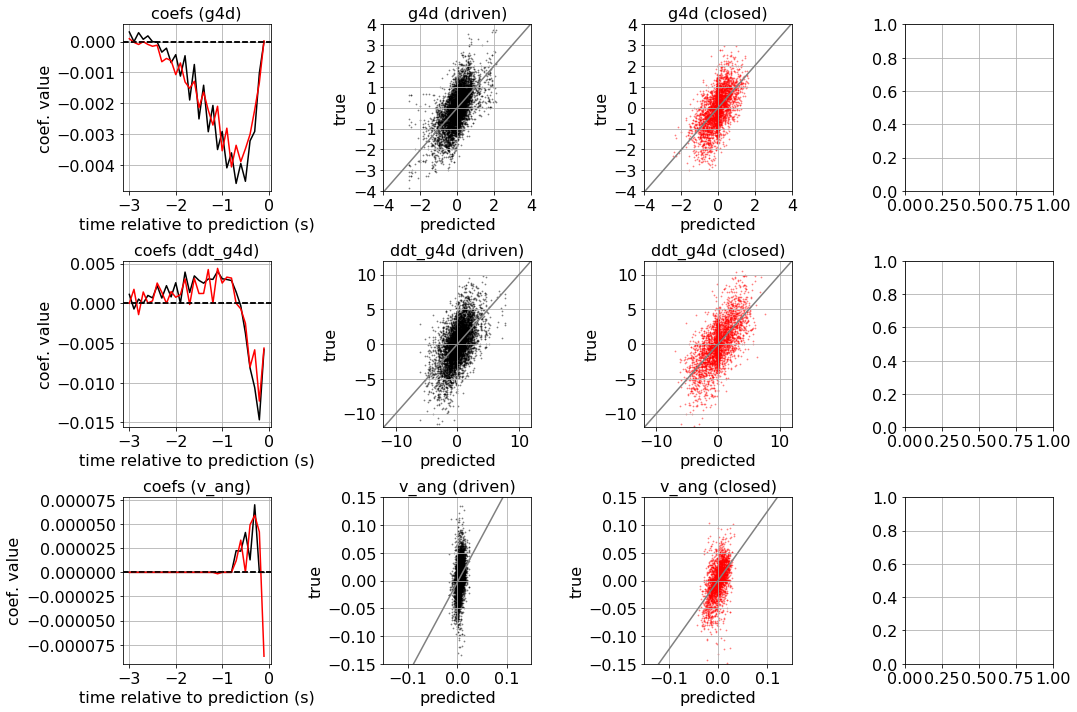

In [65]:
FILT_LEN = 30  # timesteps
CLOSED_LOOP_EPOCHS = [(0, 60), (120, 180), (240, 300)]
MODEL = Lasso(alpha=0.1)

v_airs = {'driven': [], 'closed': []}
g4ds = {'driven': [], 'closed': []}
ddt_g4ds = {'driven': [], 'closed': []}
v_angs = {'driven': [], 'closed': []}

valid = {'driven': None, 'closed': None}
targs = {'driven': None, 'closed': None}
rgrs = {'driven': None, 'closed': None}
errs = {'driven': None, 'closed': None}

for trial in trials:
    
    t = trial.dl.t
    
    # prepare driven predictors and targets
    for ctr, (t_start, t_end) in enumerate(C.DRIVEN_RANDOM_EPOCHS):
        mask = (t_start <= t) & (t < t_end)
    
        # get epoch
        t_ = t[mask]
        v_air_ = trial.dl.v_air[mask]
        g4d = trial.dl.g4d[mask]
        ddt_g4d = trial.dl.ddt_g4d[mask]
        v_ang = trial.dl.v_ang[mask]
    
        # remove 10s following odor onset (only applicable in first epoch)
        odor_onset_mask = (C.ODOR_START <= t_) & (t_ < C.ODOR_START+10)
        g4d[odor_onset_mask] = np.nan
        ddt_g4d[odor_onset_mask] = np.nan
        v_ang[odor_onset_mask] = np.nan
    
        # get full v_air predictor matrix
        v_air = make_extended_predictor_matrix(
            vs={'v_air': v_air_}, windows={'v_air': (-FILT_LEN, 0)}, order=['v_air'])
    
        # store results
        v_airs['driven'].append(v_air.copy())
        g4ds['driven'].append(g4d.copy())
        ddt_g4ds['driven'].append(ddt_g4d.copy())
        v_angs['driven'].append(v_ang.copy())
    
    # prepare closed loop predictors and targets
    for ctr, (t_start, t_end) in enumerate(CLOSED_LOOP_EPOCHS):
        mask = (t_start <= t) & (t < t_end)
    
        # get epoch
        t_ = t[mask]
        air = trial.dl.air[mask]
        v_air_ = trial.dl.v_air[mask]
        g4d = trial.dl.g4d[mask]
        ddt_g4d = trial.dl.ddt_g4d[mask]
        v_ang = trial.dl.v_ang[mask]
    
        # remove 10s following odor offset (only applicable in second epoch)
        odor_onset_mask = (C.ODOR_END <= t_) & (t_ < C.ODOR_END+10)
        g4d[odor_onset_mask] = np.nan
        ddt_g4d[odor_onset_mask] = np.nan
        v_ang[odor_onset_mask] = np.nan
        
        # remove all points where the air tube is greater than 45 deg from uw
        air_invalid_mask = np.abs(air) >= 45
        v_air_[air_invalid_mask] = np.nan
    
        # get full v_air predictor matrix
        v_air = make_extended_predictor_matrix(
            vs={'v_air': v_air_}, windows={'v_air': (-FILT_LEN, 0)}, order=['v_air'])
    
        # store results
        v_airs['closed'].append(v_air.copy())
        g4ds['closed'].append(g4d.copy())
        ddt_g4ds['closed'].append(ddt_g4d.copy())
        v_angs['closed'].append(v_ang.copy())
    
# fit models
for cdtn in ['driven', 'closed', 'control']:
    
    if cdtn != 'control':
        # concatenate data into full predictor matrix and targ vectors
        v_airs[cdtn] = cc(v_airs[cdtn], axis=0)
        g4ds[cdtn] = cc(g4ds[cdtn], axis=0)[:, None]
        ddt_g4ds[cdtn] = cc(ddt_g4ds[cdtn], axis=0)[:, None]
        v_angs[cdtn] = cc(v_angs[cdtn], axis=0)[:, None]

        # remove nans
        valid[cdtn] = np.all(
            ~np.isnan(cc([v_airs[cdtn], g4ds[cdtn], ddt_g4ds[cdtn], v_angs[cdtn]], axis=1)), axis=1)

        targs[cdtn] = cc([g4ds[cdtn], ddt_g4ds[cdtn], v_angs[cdtn]], axis=1)

    else:
        # build positive control dataset using closed loop v_air inputs passed through
        # best-fit open loop filters
        v_airs[cdtn] = v_airs['closed'].copy()
        valid[cdtn] = valid['closed'].copy()
        targs[cdtn] = np.nan * np.zeros((len(v_airs['closed']), 3))
        targs[cdtn][valid['closed'], :] = rgrs['driven'].predict(v_airs['closed'][valid['closed']])
        # add noise
        targs[cdtn] += errs['closed']
        
    # fit linear regression
    rgrs[cdtn] = deepcopy(MODEL)
    rgrs[cdtn].fit(v_airs[cdtn][valid[cdtn]], targs[cdtn][valid[cdtn]])
    
    errs[cdtn] = np.nan * np.zeros(targs[cdtn].shape)
    errs[cdtn][valid[cdtn]] = targs[cdtn][valid[cdtn]] - rgrs[cdtn].predict(v_airs[cdtn][valid[cdtn]])
    
# plot found filters
LIMS = {'g4d': (-4, 4), 'ddt_g4d': (-12, 12), 'v_ang': (-.15, .15)}

fig, axs = plt.subplots(3, 4, figsize=(15, 10), tight_layout=True)

for t_ctr, label in enumerate(['g4d', 'ddt_g4d', 'v_ang']):
    for cdtn, color, scatter_ax in zip(['driven', 'closed'], ['k', 'r', 'b'], [1, 2, 3]):
        
        # filters
        axs[t_ctr, 0].plot(C.DT * np.arange(-FILT_LEN, 0), rgrs[cdtn].coef_[t_ctr], color=color)
        axs[t_ctr, 0].axhline(0, color='k', ls='--')
        
        axs[t_ctr, 0].set_xlabel('time relative to prediction (s)')
        axs[t_ctr, 0].set_ylabel('coef. value')
        axs[t_ctr, 0].set_title('coefs ({})'.format(label))

        # true vs predicted scatter
        x = rgrs[cdtn].predict(v_airs[cdtn][valid[cdtn]])[:, t_ctr]
        y = targs[cdtn][valid[cdtn], t_ctr]
        
        axs[t_ctr, scatter_ax].scatter(x, y, s=3, alpha=.5, c=color, lw=0)
        
        # best fit line of true vs predicted
        slp, icpt, _, _, _ = linregress(x, y)
        x_line = np.array(LIMS[label])
        y_line = slp*x_line + icpt
        
        axs[t_ctr, scatter_ax].plot(x_line, y_line, color='gray')
        
        axs[t_ctr, scatter_ax].set_xlim(LIMS[label])
        axs[t_ctr, scatter_ax].set_ylim(LIMS[label])
        
        axs[t_ctr, scatter_ax].set_xlabel('predicted')
        axs[t_ctr, scatter_ax].set_ylabel('true')
        axs[t_ctr, scatter_ax].set_title('{} ({})'.format(label, cdtn))
    
    for ax in axs[t_ctr]:
        ax.grid()
        set_font_size(ax, 16)

And indeed, we now see that the filters for the closed loop and driven conditions look much more similar. This suggests that the observed weakening of the signal representation might have been due to the fact that in closed loop the air tube spends more time at the fly's side, as opposed to in front of it, whereas in the driven condition it is almost always in front of the fly. This means that the representation of the air tube velocity is likely gated by the air tube's position relative to the fly.

Loading clean data from file "clean_0.csv"...


/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater_equal


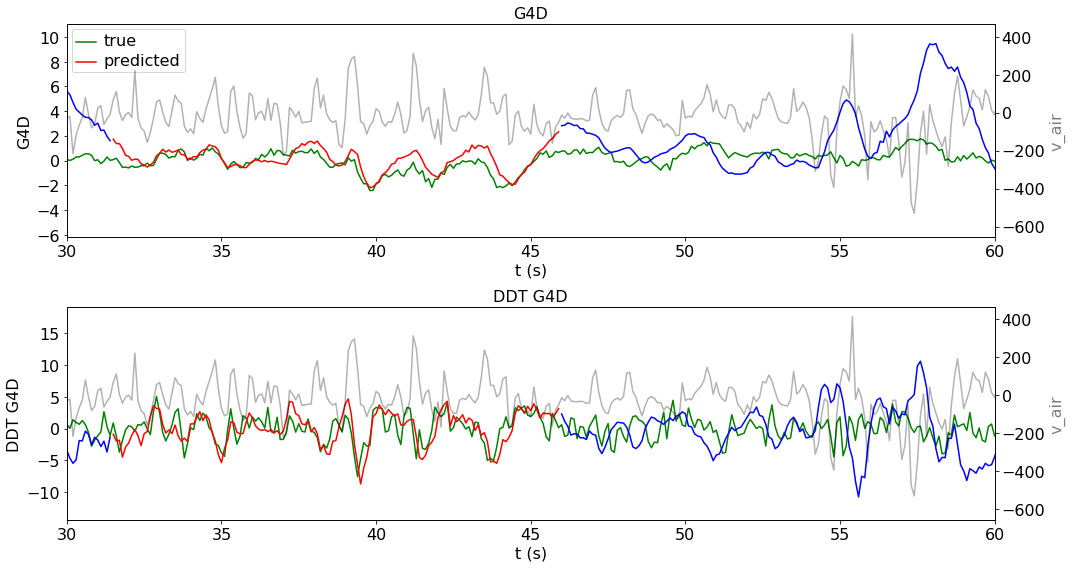

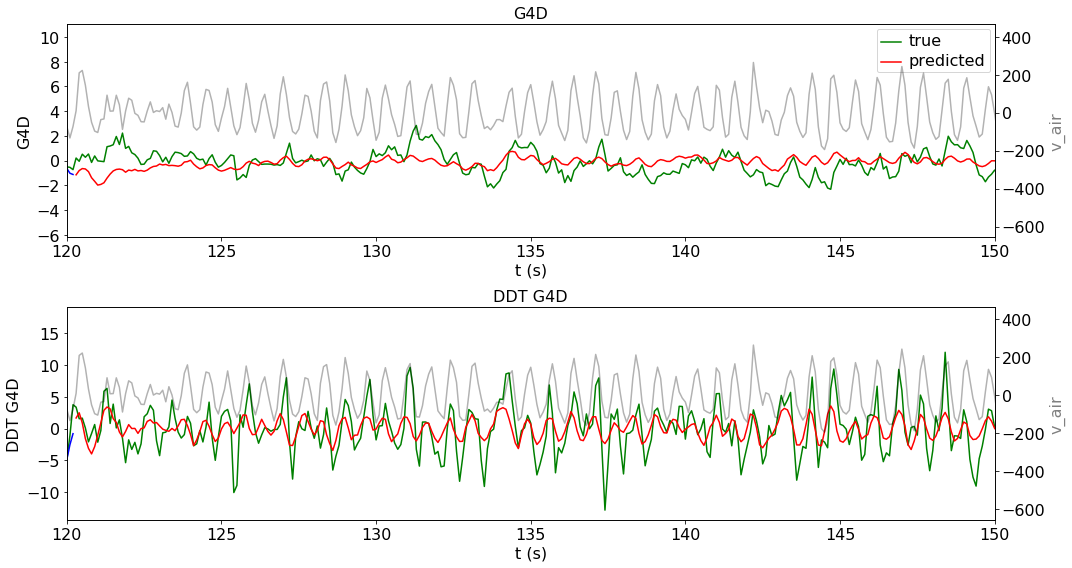

In [76]:
from data import get_trial

trial = get_trial('20170428.Fly2.2')
trial.dl = DataLoader(trial, sfx=0, vel_filt=None)

t = trial.dl.t.copy()
air = trial.dl.air.copy()
v_air = trial.dl.v_air.copy()
g4d = trial.dl.g4d[:, None].copy()
ddt_g4d = trial.dl.ddt_g4d[:, None].copy()

v_air_ = make_extended_predictor_matrix(
    vs={'v_air': v_air}, windows={'v_air': (-FILT_LEN, 0)}, order=['v_air'])

no_nan = np.all(~np.isnan(cc([v_air_, g4d, ddt_g4d], axis=1)), axis=1)

g4d_pr = np.nan * np.zeros(g4d.shape).flatten()
ddt_g4d_pr = np.nan * np.zeros(ddt_g4d.shape).flatten()

g4d_pr[no_nan] = rgrs[cdtn].predict(v_air_[no_nan])[:, 0]
ddt_g4d_pr[no_nan] = rgrs[cdtn].predict(v_air_[no_nan])[:, 1]

T_LIMS = [(30, 60), (120, 150)]

air_ = make_extended_predictor_matrix(
    vs={'air': air}, windows={'air': (-20, 0)}, order=['air'])

air_invalid_mask = np.any(np.abs(air_) >= 90, axis=1)

for t_lim in T_LIMS:
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)
    axs_twin = []
    
    # G4D
    axs[0].plot(t, trial.dl.g4d, color='g')
    
    # plot when air tube is valid
    t_ = t.copy()
    t_[air_invalid_mask] = np.nan
    
    axs[0].plot(t_, g4d_pr, color='r')
    axs[0].legend(['true', 'predicted'])
    
    # plot when air tube is invalid
    t_ = t.copy()
    t_[~air_invalid_mask] = np.nan
    
    axs[0].plot(t_, g4d_pr, color='b')
    
    axs[0].set_ylabel('G4D')
    axs[0].set_title('G4D')
    axs_twin.append(axs[0].twinx())
    axs_twin[0].plot(t, trial.dl.v_air, color='k', alpha=0.3)
    
    # DDT G4D
    axs[1].plot(t, trial.dl.ddt_g4d, color='g')
    
    # plot when air tube is valid
    t_ = t.copy()
    t_[air_invalid_mask] = np.nan
    
    axs[1].plot(t_, ddt_g4d_pr, color='r')
    
    # plot when air tube is invalid
    t_ = t.copy()
    t_[~air_invalid_mask] = np.nan
    
    axs[1].plot(t_, ddt_g4d_pr, color='b')
    
    axs[1].set_ylabel('DDT G4D')
    axs_twin.append(axs[1].twinx())
    axs_twin[1].plot(t, trial.dl.v_air, color='k', alpha=0.3)

    axs[1].set_title('DDT G4D')

    for ax in axs:
        ax.set_xlim(*t_lim)
        ax.set_xlabel('t (s)')
        set_font_size(ax, 16)

    for ax in axs_twin:
        ax.set_ylabel('v_air', color='gray')
        set_font_size(ax, 16)